In [78]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import os

from torchsummary import summary
import seaborn as sns
%matplotlib inline

In [79]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [80]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
!gzip -d imagewoof2-320.tgz
!tar -xvf imagewoof2-320.tar 

Выходные данные были обрезаны до нескольких последних строк (5000).
imagewoof2-320/train/n02111889/n02111889_2643.JPEG
imagewoof2-320/train/n02111889/n02111889_14108.JPEG
imagewoof2-320/train/n02111889/n02111889_259.JPEG
imagewoof2-320/train/n02111889/n02111889_4237.JPEG
imagewoof2-320/train/n02111889/n02111889_5778.JPEG
imagewoof2-320/train/n02111889/n02111889_6356.JPEG
imagewoof2-320/train/n02111889/n02111889_8728.JPEG
imagewoof2-320/train/n02111889/n02111889_5679.JPEG
imagewoof2-320/train/n02111889/n02111889_9018.JPEG
imagewoof2-320/train/n02111889/n02111889_3146.JPEG
imagewoof2-320/train/n02111889/n02111889_5567.JPEG
imagewoof2-320/train/n02111889/n02111889_15505.JPEG
imagewoof2-320/train/n02111889/n02111889_15719.JPEG
imagewoof2-320/train/n02111889/n02111889_2944.JPEG
imagewoof2-320/train/n02111889/n02111889_11487.JPEG
imagewoof2-320/train/n02111889/n02111889_2867.JPEG
imagewoof2-320/train/n02111889/n02111889_12879.JPEG
imagewoof2-320/train/n02111889/n02111889_5968.JPEG
imagewoof2

In [81]:
from PIL import Image
#train
images_train = []
labels_train = []
folderNames = ["n02086240", "n02087394", "n02088364", "n02089973", "n02093754", "n02096294", "n02099601", "n02105641", "n02111889", "n02115641"]
y = 0
for folderName in folderNames:
  for root, dirs, files in os.walk("/content/imagewoof2-320/train/" + folderName, 
                                  topdown=False):
    for name in files:
      img = Image.open(os.path.join(root, name)).resize((320, 426))
      img = np.array(img)
      if (len(img.shape) < 3):
        images_train.append(img.reshape((426, 320, 1)))
      else:
        images_train.append(img[:,:,0].reshape((426, 320, 1)))
      labels_train.append(y)
  y = y + 1

In [19]:
labels_train[0]

0

In [82]:
#val 
images_val = []
labels_val = []
folderNames = ["n02086240", "n02087394", "n02088364", "n02089973", "n02093754", "n02096294", "n02099601", "n02105641", "n02111889", "n02115641"]
y = 0
for folderName in folderNames:
  for root, dirs, files in os.walk("/content/imagewoof2-320/val/" + folderName, 
                                  topdown=False):
    for name in files:
      img = Image.open(os.path.join(root, name)).resize((320, 426))
      img = np.array(img)
      if (len(img.shape) < 3):
        images_val.append(img.reshape((426, 320, 1)))
      else:
        images_val.append(img[:,:,0].reshape((426, 320, 1)))
      labels_val.append(y)
  y = y + 1

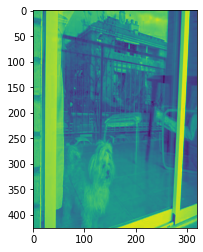

In [14]:
plt.imshow(images_train[5].reshape(426, 320))
plt.show()

In [25]:
train_loader = torch.utils.data.DataLoader(([images_train, labels_train]), batch_size=64)
#val_loader = torch.utils.data.DataLoader([[images_val, labels_val]], batch_size=64)

In [42]:
train_loader_y = torch.utils.data.DataLoader(labels_train, batch_size=64)

In [62]:
h = next(iter(train_loader))

In [65]:
h[0].shape


torch.Size([64, 426, 320, 1])

In [44]:
g = next(iter(labels_loader))

NameError: ignored

In [47]:
h.shape

torch.Size([64, 1])

In [22]:
batch_image_train

[tensor([[[[149],
           [150],
           [151],
           ...,
           [ 69],
           [ 81],
           [ 82]],
 
          [[148],
           [149],
           [151],
           ...,
           [ 67],
           [ 77],
           [ 79]],
 
          [[147],
           [149],
           [151],
           ...,
           [ 67],
           [ 75],
           [ 76]],
 
          ...,
 
          [[155],
           [156],
           [161],
           ...,
           [156],
           [157],
           [167]],
 
          [[156],
           [153],
           [157],
           ...,
           [151],
           [159],
           [164]],
 
          [[159],
           [151],
           [152],
           ...,
           [148],
           [162],
           [162]]]], device='cuda:0', dtype=torch.uint8), tensor([[[[ 72],
           [ 73],
           [ 73],
           ...,
           [106],
           [102],
           [100]],
 
          [[ 73],
           [ 74],
           [ 74],
    

In [31]:
class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [83]:
import math
import torch
import random
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [94]:
class CNN(nn.Module):
  def __init__(self, width = 320, height = 426, channels = 1, classes = 10):
    super(CNN, self).__init__()

    self.width, self.height, self.channels = width, height, channels
    self.input_shape = (height, width, channels)
    self.classes = classes

    # Layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding= 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding= 2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 2)
    self.batch1 = nn.BatchNorm2d(32)
    self.batch2 = nn.BatchNorm2d(128)
    self.batch3 = nn.BatchNorm1d(512)
    self.batch4 = nn.BatchNorm1d(128)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features = 46208, out_features=2048)
    self.linear2 = nn.Linear(in_features = 2048, out_features=512)
    self.linear3 = nn.Linear(in_features = 512,out_features=128)
    self.out = nn.Linear(in_features = 128,out_features=10)
    
  
  def feature_extractor(self, inp):

    #conv1
    t = self.conv1(inp)
    t = F.relu(t)
    t = self.batch1(t)
    t = self.dropout1(t)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = self.batch1(t)
    t = self.dropout1(t)
    
    # conv 3
    t = self.conv3(t)
    t = F.relu(t)
    t = nn.MaxPool2d(kernel_size=2, stride=2)(t)
    t = self.dropout1(t)

    #conv 4
    t = self.conv4(t)
    t = F.relu(t)
    t = self.batch2(t)
    t = self.dropout1(t)

    #Flatten
    output = self.flatten(t)

    return output

  def classifier(self, inp):
    t = self.linear1(inp)
    t = dropout2(t)
    t = self.linear2(t)
    t = self.linear3(t)
    t = dropout2(t)
    output = self.out(t)

    return output


  def forward(self, input):
    
    feature_output = self.feature_extractor(input)

    classifier_output = self.classifier(feature_output)
    
    return classifier_output           


In [95]:
model = CNN(width = 320, height = 426, channels = 1, classes = 10)

n_epochs = 600
lr=0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=46208, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  

In [11]:
from keras.utils import to_categorical
num_classes = 10

In [90]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
from keras.utils import to_categorical
num_classes = 10
example_batch = next(iter(train_loader))
example_batch[1] = torch.from_numpy(to_categorical(example_batch[1], num_classes= num_classes))
batch_image_train = [x.to(device) for x in example_batch]

example_x = example_batch[0][0]
example_y = example_batch[1][0]

In [69]:
example_batch[0].shape

torch.Size([64, 426, 320, 1])

In [32]:
import torchvision
data_root = './'


a =torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        
        download=True
    )

In [35]:
a[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F39F5DFB668>, 5)

In [86]:
images_train = np.array(images_train)

In [87]:
labels_train = np.array(labels_train)

In [23]:
print(images_train.shape)

(9025, 426, 320, 1)


In [88]:
labels_train = labels_train.reshape(-1,1)

In [26]:
print(labels_train.shape)

(9025, 1)


In [31]:
b = np.stack((images_train, labels_train))

ValueError: ignored

In [62]:
b = (images_train, labels_val)

In [ ]:
batch = next(iter(train_loader))


In [89]:
dataset = []
for i in range(9025):
  dataset.append((images_train[i], labels_train[i]))

In [59]:
list[800][1]

array([0])

In [53]:
for batch in (iter(train_loader), iter(train_loader_y)):
  print(batch)
  

In [96]:
#train
losses = []
num_epoch = 50
min = 5
for epoch_num in tqdm.tnrange(num_epoch):
  model.train()
  for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
    #images = Variable(images.float())
    #labels = Variable(labels)
    print(batch_x.shape)
    print(batch_label.shape)
    batch_x = torch.reshape(batch_x, (64, 1, 426, 320))
    batch_x = batch_x.to(device = device, dtype=torch.float)
    batch_label = torch.from_numpy(to_categorical(batch_label, num_classes= num_classes))
    batch_label = batch_label.to(device)
    #images = torch.Tensor(images)
    
    # Forward + Backward + Optimize
    optimizer.zero_grad()
    outputs = model(batch_x)
    loss = criterion(outputs, batch_label)

    loss.backward()
    optimizer.step()
    
    losses.append(loss.data)
      
    if (i+1) % 100 == 0:
        print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                %(epoch+1, num_epoch, i+1, len(train), loss.data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


torch.Size([64, 426, 320, 1])
torch.Size([64, 1])



RuntimeError: ignored

In [ ]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = torch.from_numpy(to_categorical(batch_label, num_classes= num_classes))
            batch_label = batch_label.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)

            kl_loss = 0.5 * torch.mean(torch.sum(
              mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values,
                      dim=1))
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            clear_output(True)
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num, True)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs